# Scalability and sustainable throughput
This notebook can be used to make scalability and sustainable throughput plots.

In [1]:
# settings for saving plots
saveplots = True
dpiResolution = 100

In [2]:
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
# Import to indent the plots in the notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from IPython.core.display import display, HTML
from PIL import Image
warnings.simplefilter('ignore', Image.DecompressionBombWarning)
import datetime
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

In [3]:
from pyspark.sql import Window
from pyspark.sql import functions
from pyspark.sql.types import IntegerType, LongType, DoubleType, TimestampType, StringType

In [4]:
# check if Spark is running
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['figure.edgecolor'] = 'lightgrey'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] ='bold'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] ='out'
plt.rcParams["date.autoformatter.minute"] = "%H:%M"
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('axes',edgecolor='black')

In [40]:
# check if Spark is running
spark

In [7]:
# List of which frameworks should be included in this comparison
frameworksPrinted = {
    "SPARK": "Spark Streaming",
    "STRUCTUREDSTREAMING": "Structured Streaming",
    "FLINK": "Flink",
    "KAFKASTREAMS": "Kafka Streams"
}
stages=["ingest", "parse", "join", "tumbling \n window", "sliding \n window"]

In [8]:
cluster_scales = {
    "baseline": "5x-4cpu-20gb",
    "horizontal": "10x-4cpu-20gb",
    "vertical": "5x-8cpu-40gb"
}









## General Methods

For printing the quantiles of a column:
provide a list of quantiles

In [9]:
def dataRate(factor, last_stage):
    if(int(last_stage)<100):
        return 380*(int(factor)+1)
    else:
        return 190*(int(factor)+1)

dataRateUDF = functions.udf(dataRate, IntegerType())

def factorToTotalCount(factor, last_stage):
    if(int(last_stage)<100):
        return int(380*(int(factor)+1)*30*60/3.1666666667)
    else:
        return 120*30*60*(int(factor)+1)

factorToTotalCountUDF = functions.udf(factorToTotalCount, IntegerType())

In [16]:
def save_img_colored_and_grayscale(path_colored_img):
    if saveplots: 
        plt.savefig(path_colored_img + '.png', dpi=dpiResolution, bbox_inches="tight", pad_inches=0)

# Horizontal scale 
Read in latency data and transform in the right format for plotting.

In [18]:
def createFrameworkSustainableBurstPlot(completeResults, last_stage, framework, amt_workers, cpu_reservation, memory_reservation):
    latency_metric = 'p50'
    f, ax = plt.subplots(3, 1, figsize=(2.5, 2.7), sharex=True)
    xlim = 1000000
    if(int(last_stage)<100):
        max_allowed_latency = 10000
    else:
        max_allowed_latency = 90000
        
    print(framework + " - " + amt_workers + "x-" + cpu_reservation +"cpu-" + memory_reservation + "gb")
    data = completeResults\
        .withColumn("scale", col("scale").cast("Integer"))\
        .orderBy('scale')
    
    dfToPlot = data\
        .withColumn("expectedCount", factorToTotalCountUDF(col("scale"), lit(last_stage)))\
        .withColumn("missingCount", col("expectedCount")-col("count"))\
        .withColumn("delayTime", col("max_outputKafkaTimestamp")-col("max_inputKafkaTimestamp"))\
        .withColumn("meanCpuPct", col("mean_cpu")*100/cpu_reservation)\
        .withColumn("p50", col("p50").cast("Integer"))\
        .withColumn("p99", col("p99").cast("Integer"))\
        .withColumn("mean_mem", col("mean_mem").cast("Float"))\
        .withColumn("min_mem", col("min_mem").cast("Float"))\
        .withColumn("max_mem", col("max_mem").cast("Float"))
        
    dfToPlotPandas = dfToPlot.toPandas()
    delayedData = dfToPlot.filter((col("meanCpuPct")>80) | (col("p50")>max_allowed_latency)).toPandas()
    notDelayedData = dfToPlot.filter((col("meanCpuPct")<80) & (col("p50")<max_allowed_latency)).toPandas()
    beginningGreyZone = notDelayedData['scale'].apply(lambda x: dataRate(x, last_stage)).max()
    
    dataSummary = dfToPlot.withColumn("missingPct", col("missingCount")/col("expectedCount"))\
        .withColumn("throughput", dataRateUDF(col("scale"), lit(last_stage)))\
        .select("scale", "throughput", round("missingPct").alias("missingPct"),\
                "delayTime", "p50", "p99", round("meanCpuPct").alias("meanCpuPct"), "mean_mem", "filename")\
        .orderBy("scale")
    dataSummary.show()
    dataSummary.drop("fileName", "mean_mem").show()
    
    ax[0].axvspan(beginningGreyZone, xlim, facecolor='grey', alpha=0.5)
    latency_line = ax[0].plot(notDelayedData['scale'].apply(lambda x: dataRate(x, last_stage)), notDelayedData[latency_metric], marker= 'o', markersize=3.5, label='p50 latency', c='#303030', zorder=2)
    ax[0].set_ylabel('latency', rotation='horizontal', labelpad =40, verticalalignment='center')

    maxLatencyNotDelayed = notDelayedData[latency_metric].max()
    ylimitmax = maxLatencyNotDelayed*1.5 if int(last_stage) < 100 else 60000

    ax[0].set_ylim(ymin=0, ymax=ylimitmax)
    ax[0].set_xlim(xmin=0, xmax=xlim)
    # Make it SECONDS y-axis scale instead of MILLIS
    ax[0].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000), ',').replace(',', ' ') + " s"))
    ax[0].spines['bottom'].set_color('grey')
    ax[0].spines['bottom'].set_visible(True)
    ax[0].spines['left'].set_color('grey')
    ax[0].spines['left'].set_visible(True)
    minor_y_locator_0 = AutoMinorLocator(2)
    ax[0].yaxis.set_minor_locator(minor_y_locator_0)
    ax[0].grid(which='minor', color='grey')
    ax[0].axvline(beginningGreyZone, color='black')

    dataToPlot = dfToPlot.toPandas()
    dataToPlot['scale'] = dataToPlot['scale'].apply(lambda x: dataRate(x, last_stage))
    ax[1].plot(dataToPlot['scale'], dataToPlot['meanCpuPct'], linestyle= '--', marker='o', 
               label='mean CPU', c='#303030', zorder=2, markersize=3.5)
    ax[1].set_ylabel('CPU', rotation='horizontal', horizontalalignment='right', verticalalignment='center')
    ax[1].set_ylim(ymin=0, ymax=120)
    ax[1].axvspan(beginningGreyZone, xlim, facecolor='grey', alpha=0.5)
    ax[1].spines['bottom'].set_color('grey')
    ax[1].spines['bottom'].set_visible(True)
    ax[1].spines['left'].set_color('grey')
    ax[1].spines['left'].set_visible(True)
    minor_y_locator_1 = AutoMinorLocator(2)
    ax[1].yaxis.set_minor_locator(minor_y_locator_1)
    ax[1].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x).replace('.0', '') + " %"))
    ax[1].grid(which='minor', color='grey')
    ax[1].axvline(beginningGreyZone, color='black')

    ax[2].plot(dataToPlot['scale'], dataToPlot['mean_mem'], linestyle = ":", marker= 'o', markersize=3.5, label='avg heap usage', c='black', zorder=2)            
    ax[2].fill_between(dataToPlot['scale'], dataToPlot['min_mem'], dataToPlot['max_mem'], color='grey', label='heap usage range')
    ax[2].set_ylabel('mem', rotation='horizontal', horizontalalignment='right', verticalalignment='center')
    ax[2].set_yticks([0, 15*1024])
    ax[2].set_xlabel('x100K events/sec')
    ax[2].spines['bottom'].set_color('grey')
    ax[2].spines['bottom'].set_visible(True)
    ax[2].spines['left'].set_color('grey')
    ax[2].spines['left'].set_visible(True)
    ax[2].set_ylim(ymin=0, ymax=30*1024)
    minor_y_locator_2 = AutoMinorLocator(2)
    ax[2].yaxis.set_minor_locator(minor_y_locator_2)
    ax[2].grid(which='minor', color='grey')
    ax[2].axvspan(beginningGreyZone, xlim, facecolor='grey', alpha=0.5, label = 'unsustainable')
    ax[2].axvline(beginningGreyZone, color='black')

    # Make it GB instead of the real MB values on the y axis
    ax[2].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1024.0), ',').replace(',', ' ') + " GB"))
    # Make it x1000 seconds instead of the real too large values on the x axis
    ax[2].get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/100000.0), ',').replace(',', ' ')))
    
    ax[2].set_xticks(range(0, xlim, 100000))

    save_img_colored_and_grayscale("./figures/scalability/overall/sustainable_throughput_stage" + last_stage + "_" + framework + "_"  + amt_workers + "x_" + cpu_reservation +"cpu_" + memory_reservation + "g")
    
    dataSummary.coalesce(1).write.mode("overwrite").csv("./figures/scalability/overall/sustainable_throughput_summary_" + framework + "_"  + amt_workers + "x-" + cpu_reservation +"cpu-" + memory_reservation + "gb_scale")
    plt.show()

Phases that are present in the data

In [19]:
def getPlotsAndInfoForScale(framework, last_stage, amt_workers, cpu_reservation, memory_reservation):
    dataPath = "./scalability-data/constant-rate/" + framework + "/stage" + last_stage + "/" + amt_workers + "x-" + cpu_reservation +"cpu-" + memory_reservation + "gb/*"
    completeResults = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/results.csv/*").withColumn("filename", split(input_file_name(), "/202").getItem(1))
    if completeResults.count()>0:
        volumes = list(completeResults.select("scale").distinct().orderBy("scale").toPandas()["scale"])
        
    containerCheckPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/cpu-per-container-timeseries.csv/*")
    amtOfContainers = containerCheckPhase.select("containerName").distinct().count()

    required_amt_containers = {
        "horizontal": 10,
        "vertical": 5,
        "baseline": 5
    }
    
    
    createFrameworkSustainableBurstPlot(completeResults, last_stage, framework, amt_workers, cpu_reservation, memory_reservation)
    
    print(volumes)

## Last stage 3

In [106]:
framework="STRUCTUREDSTREAMING"
last_stage="3"

STRUCTUREDSTREAMING - 6x-2cpu-10gb
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|   p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|    0|       380|     -14.0|   2915.0|  2993|  4180|      32.0| 821.2631|0-10-09T07_43_48Z...|
|  300|    114380|       1.0|   3013.0|  4942|  6687|      60.0|2993.8901|0-10-08T13_48_37Z...|
|  400|    152380|       1.0|   3476.0|  8220| 11202|      75.0| 3776.935|0-10-23T15_30_57Z...|
|  400|    152380|       1.0|   2560.0|  7661| 12201|      72.0|2409.2185|0-12-11T15_58_57Z...|
|  800|    304380|       1.0| 965040.0|728632|968493|      78.0| 3763.572|0-12-11T18_23_49Z...|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+

+-----+----------+----------+---------+------+------+----------+
|scale|throughput|missingPct|delayT

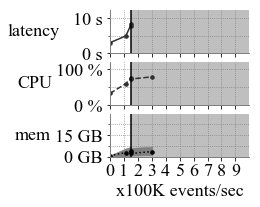

['0', '300', '400', '800']


In [107]:
getPlotsAndInfoForScale(framework, last_stage, "6", "2", "10")

STRUCTUREDSTREAMING - 2x-6cpu-30gb
+-----+----------+----------+---------+----+----+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime| p50| p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+----+----+----------+---------+--------------------+
|    0|       380|     -14.0|   2581.0|3049|4329|      24.0|1979.3666|0-10-07T16_42_00Z...|
|  300|    114380|       1.0|   2749.0|4622|6087|      53.0| 9036.653|0-10-06T12_31_06Z...|
|  400|    152380|       1.0|   2771.0|7492|9427|      74.0|12355.045|0-10-23T13_53_45Z...|
|  400|    152380|       1.0|   2783.0|null|null|      76.0| 9346.157|0-12-09T16_41_44Z...|
|  450|    171380|       1.0| 292408.0|null|null|      86.0|13687.503|0-10-23T11_02_05Z...|
|  600|    228380|       1.0| 208436.0|null|null|      93.0|14429.034|0-10-07T17_19_09Z...|
+-----+----------+----------+---------+----+----+----------+---------+--------------------+

+-----+----------+----------+---------+----+

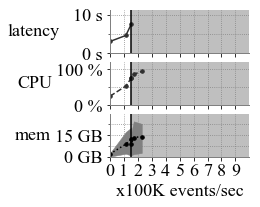

['0', '300', '400', '450', '600']


In [108]:
getPlotsAndInfoForScale(framework, last_stage, "2", "6", "30")

STRUCTUREDSTREAMING - 6x-6cpu-30gb
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|  p50|  p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+
|    0|       380|     -23.0|     5042| 4543| 5930|      15.0|1880.1241|0-10-17T15_38_27Z...|
|  800|    304380|       1.0|     5468| 7339| 9688|      51.0| 6457.486|0-10-15T18_37_05Z...|
|  900|    342380|       1.0|     4113| 8278|10534|      60.0|7216.3438|0-10-19T07_09_40Z...|
| 1000|    380380|       1.0|     4347|10344|13334|      65.0|  8916.23|0-10-17T16_15_46Z...|
| 1100|    418380|       1.0|     4499|10732|13765|      69.0|10730.667|0-10-18T08_30_27Z...|
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+

+-----+----------+----------+---------+-----+-----+----------+
|scale|throughput|missingPct|delayTime|  p50|  p99|mean

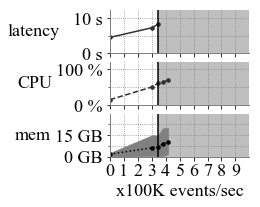

[0, 800, 900, 1000, 1100]


In [109]:
getPlotsAndInfoForScale(framework, last_stage, "6", "6", "30")

STRUCTUREDSTREAMING - 6x-4cpu-20gb
+-----+----------+----------+---------+-----+------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|  p50|   p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+-----+------+----------+---------+--------------------+
|    0|       380|     -14.0|   4753.0| 3860|  5309|      15.0| 1197.533|0-10-13T17_56_31Z...|
|  400|    152380|       1.0|   3338.0| 5362|  7126|      44.0|3457.9941|0-10-14T08_33_04Z...|
|  800|    304380|       1.0|   4545.0| 9748| 13211|      69.0| 8692.669|0-10-13T13_15_20Z...|
|  850|    323380|       1.0|  73110.0|91405|115606|      86.0| 7858.226|0-12-22T11_25_29Z...|
|  900|    342380|       1.0| 310503.0| null|  null|      86.0| 9713.181|0-10-13T18_33_40Z...|
+-----+----------+----------+---------+-----+------+----------+---------+--------------------+

+-----+----------+----------+---------+-----+------+----------+
|scale|throughput|missingPct|delayTime|  p50|

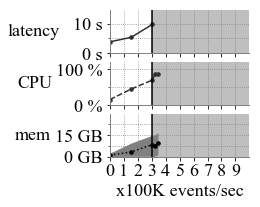

['0', '400', '800', '850', '900']


In [110]:
getPlotsAndInfoForScale(framework, last_stage, "6", "4", "20")

STRUCTUREDSTREAMING - 4x-6cpu-30gb
+-----+----------+----------+---------+-------+-------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|    p50|    p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+-------+-------+----------+---------+--------------------+
|    0|       380|     -14.0|     4557|   3517|   4934|      16.0|1532.4933|0-10-10T19_55_05Z...|
|  600|    228380|       1.0|     3488|   6192|   8265|      59.0| 8412.182|0-10-10T20_32_14Z...|
|  750|    285380|       1.0|     4220|   8062|  10616|      68.0|10266.676|0-10-11T07_50_22Z...|
|  800|    304380|       1.0|     3484|  10405|  13971|      75.0|12340.565|0-10-11T12_26_08Z...|
|  900|    342380|       1.0|  1393363|1431239|1467535|      62.0|15793.205|0-10-10T21_09_23Z...|
+-----+----------+----------+---------+-------+-------+----------+---------+--------------------+

+-----+----------+----------+---------+-------+-------+----------+
|scale|throughp

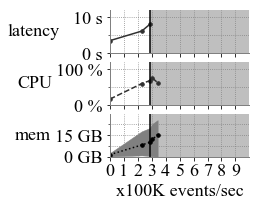

[0, 600, 750, 800, 900]


In [111]:
getPlotsAndInfoForScale(framework, last_stage, "4", "6", "30")

STRUCTUREDSTREAMING - 6x-1cpu-5gb
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|  p50|  p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+
|    0|       380|     -14.0|     2790| 3192| 4294|      36.0| 649.6797|0-12-16T11_14_51Z...|
|  100|     38380|       1.0|     3514| 4494| 6372|      56.0|1485.4652|0-12-16T11_52_02Z...|
|  150|     57380|       1.0|     3134|38862|71427|      66.0|1479.2935|0-12-16T16_01_44Z...|
|  200|     76380|       1.0|    38907|74796|87649|      79.0|1553.9178|0-12-15T17_00_54Z...|
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+

+-----+----------+----------+---------+-----+-----+----------+
|scale|throughput|missingPct|delayTime|  p50|  p99|meanCpuPct|
+-----+----------+----------+---------+-----+-----+----------+
|    0|       380|     -

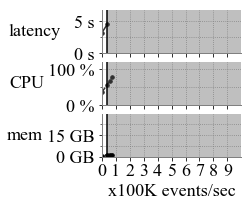

[0, 100, 150, 200]


In [112]:
getPlotsAndInfoForScale(framework, last_stage, "6", "1", "5")

STRUCTUREDSTREAMING - 1x-6cpu-30gb
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|  p50|  p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+
|    0|       380|     -14.0|     2598| 2968| 3994|      25.0|1918.7555|0-12-14T10_01_13Z...|
|  200|     76380|       1.0|     2678| 5838| 7695|      74.0| 4658.252|0-12-14T16_09_29Z...|
|  250|     95380|       1.0|    39085|52763|65004|      91.0|6862.5713|0-12-14T11_02_19Z...|
|  500|    190380|       1.0|   264491| null| null|      95.0|6035.8096|0-12-14T10_01_13Z...|
+-----+----------+----------+---------+-----+-----+----------+---------+--------------------+

+-----+----------+----------+---------+-----+-----+----------+
|scale|throughput|missingPct|delayTime|  p50|  p99|meanCpuPct|
+-----+----------+----------+---------+-----+-----+----------+
|    0|       380|     

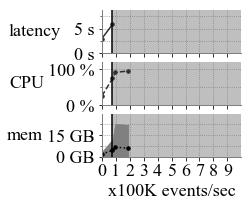

[0, 200, 250, 500]


In [113]:
getPlotsAndInfoForScale(framework, last_stage, "1", "6", "30")

## Last stage 101

In [114]:
last_stage="101"

STRUCTUREDSTREAMING - 6x-1cpu-5gb
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|    p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+
|    0|       190|       1.0|    34147|  2570|  54068|       4.0|524.87897|0-12-17T18_44_45Z...|
|  100|     19190|       1.0|    25777|  8011|  29599|      14.0| 842.8297|0-12-17T15_17_11Z...|
|  400|     76190|       1.0|    48692| 22278|  52638|      41.0|2149.3948|0-12-18T15_44_53Z...|
|  500|     95190|       1.0|    61619| 28984|  63755|      54.0|2284.0046|0-12-18T18_32_40Z...|
|  600|    114190|       1.0|  1208707|694304|1207730|      65.0|1768.6343|0-12-18T06_00_03Z...|
|  800|    152190|       1.0|   346597| 43132| 665591|      72.0|1592.1205|0-12-17T10_48_22Z...|
+-----+----------+----------+---------+------+-------+----------+---------+------------------

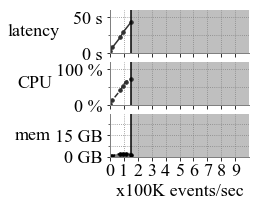

[0, 100, 400, 500, 600, 800]


In [115]:
getPlotsAndInfoForScale(framework, last_stage, "6", "1", "5")

STRUCTUREDSTREAMING - 1x-6cpu-30gb
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|   p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|    0|       190|       1.0|    43460|  1984| 59200|       2.0|1652.8647|0-12-18T00_30_34Z...|
|  600|    114190|       1.0|    47868| 31438| 64154|      52.0| 17873.38|0-12-18T03_35_39Z...|
|  700|    133190|       1.0|    55101| 38979| 56893|      61.0|  9340.48|0-12-18T09_53_53Z...|
|  900|    171190|       1.0|  1130051|526365|838455|      58.0|2814.4458|0-12-18T12_48_13Z...|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+

+-----+----------+----------+---------+------+------+----------+
|scale|throughput|missingPct|delayTime|   p50|   p99|meanCpuPct|
+-----+----------+----------+---------+------+------+----------+
|

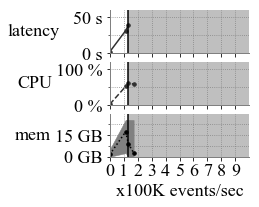

[0, 600, 700, 900]


In [116]:
getPlotsAndInfoForScale(framework, last_stage, "1", "6", "30")

STRUCTUREDSTREAMING - 6x-6cpu-30gb
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|   p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|    0|       190|       1.0|     1844|  1690|  6961|       1.0| 806.6023|0-12-24T12_14_31Z...|
|    0|       190|       1.0|    24813|  1773| 33006|       1.0| 881.9435|0-12-23T17_35_03Z...|
| 2000|    380190|       1.0|    52926| 17311| 56610|      28.0|12034.369|0-12-24T12_51_45Z...|
| 4000|    760190|       1.0|    59342| 39598| 58106|      61.0|17721.502|0-12-23T10_48_19Z...|
| 4400|    836190|       1.0|    60025| 43553| 61175|      67.0|15266.538|0-12-23T13_17_21Z...|
| 4600|    874190|       1.0|    56716| 45834| 57877|      71.0|18147.463|0-12-23T18_12_24Z...|
| 4700|    893190|       1.0|    60376| 45866| 60918|      74.0|16138.448|0-12-24T09_40_52Z...|
| 480

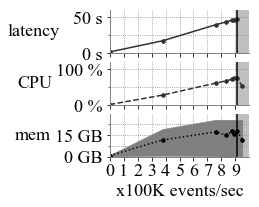

[0, 2000, 4000, 4400, 4600, 4700, 4800, 5000]


In [117]:
getPlotsAndInfoForScale(framework, last_stage, "6", "6", "30")

STRUCTUREDSTREAMING - 6x-4cpu-20gb
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|    p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+
|    0|       190|       1.0|    56475|  1704|  59742|       1.0|617.66003|0-12-19T15_30_34Z...|
| 2000|    380190|       1.0|    44102| 26072|  50283|      41.0| 9312.286|0-12-19T17_05_57Z...|
| 3000|    570190|       1.0|    55820| 41131|  55422|      66.0|12461.232|0-12-20T08_12_45Z...|
| 3100|    589190|       1.0|    45820| 42517|  50204|      69.0|12253.572|0-12-21T16_03_24Z...|
| 3250|    617690|       1.0|   822626|502748| 788381|      62.0|11071.525|0-12-20T13_30_02Z...|
| 3500|    665190|       1.0|  1301844|645528|1096182|      54.0| 9585.943|0-12-20T10_46_10Z...|
+-----+----------+----------+---------+------+-------+----------+---------+-----------------

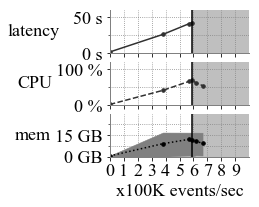

[0, 2000, 3000, 3100, 3250, 3500]


In [118]:
getPlotsAndInfoForScale(framework, last_stage, "6", "4", "20")

STRUCTUREDSTREAMING - 4x-6cpu-30gb
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|   p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+
|    0|       190|       1.0|    41913|  1905| 46746|       2.0| 891.0377|0-12-21T08_03_35Z...|
| 2000|    380190|       1.0|    45104| 26072| 62348|      40.0|12566.268|0-12-19T21_11_38Z...|
| 3000|    570190|       1.0|    51592| 42165| 57257|      68.0|18775.736|0-12-21T08_40_56Z...|
| 3100|    589190|       1.0|    60921| 44728| 66279|      72.0|  19072.9|0-12-21T12_16_38Z...|
| 3250|    617690|       1.0|   817735|807785|817233|      47.0|11202.697|0-12-20T16_47_20Z...|
+-----+----------+----------+---------+------+------+----------+---------+--------------------+

+-----+----------+----------+---------+------+------+----------+
|scale|throughput|missingPct|delayT

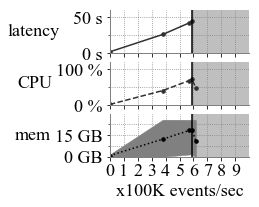

[0, 2000, 3000, 3100, 3250]


In [119]:
getPlotsAndInfoForScale(framework, last_stage, "4", "6", "30")

STRUCTUREDSTREAMING - 6x-2cpu-10gb
+-----+----------+----------+---------+-------+-------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|    p50|    p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+-------+-------+----------+---------+--------------------+
|    0|       190|       1.0|     6141|   2066|  25234|       2.0| 561.5624|0-12-24T14_35_12Z...|
| 1500|    285190|       1.0|    55038|  40224|  55763|      72.0| 5933.587|0-12-28T09_06_47Z...|
| 1600|    304190|       1.0|  1452876| 899647|1450387|      57.0| 4789.922|0-12-28T12_28_57Z...|
| 1600|    304190|       1.0|  1435244| 935489|1368438|      61.0|2718.5798|0-12-28T14_07_17Z...|
| 1700|    323190|       1.0|  1250001|1175492|1244577|      61.0|2421.4883|0-12-28T10_43_33Z...|
| 2000|    380190|       1.0|  1348158|1246910|1272224|      68.0|3405.5068|0-12-24T15_12_26Z...|
+-----+----------+----------+---------+-------+-------+----------+---------+-------

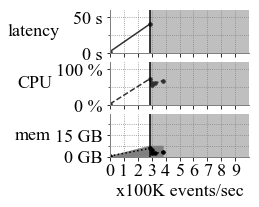

[0, 1500, 1600, 1700, 2000]


In [120]:
getPlotsAndInfoForScale(framework, last_stage, "6", "2", "10")

STRUCTUREDSTREAMING - 2x-6cpu-30gb
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+
|scale|throughput|missingPct|delayTime|   p50|    p99|meanCpuPct| mean_mem|            filename|
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+
|    0|       190|       1.0|    43003|  1931|  47944|       2.0|822.08984|0-12-24T19_10_50Z...|
| 1500|    285190|       1.0|    46496| 39964|  64790|      55.0|12711.633|0-12-29T13_11_43Z...|
| 1600|    304190|       1.0|    59490| 44195|  61046|      72.0|12766.231|0-12-29T18_53_54Z...|
| 1700|    323190|       1.0|  1244517|599344| 937398|      52.0| 6501.017|0-12-29T17_15_51Z...|
| 2000|    380190|       1.0|  1584246|737293|1314055|      50.0| 7525.122|0-12-24T19_48_04Z...|
+-----+----------+----------+---------+------+-------+----------+---------+--------------------+

+-----+----------+----------+---------+------+-------+----------+
|scale|throughput|missing

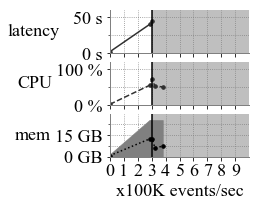

[0, 1500, 1600, 1700, 2000]


In [121]:
getPlotsAndInfoForScale(framework, last_stage, "2", "6", "30")